## Massachusetts Roads Dataset UNET

In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [4]:
!pip install -q -U segmentation-models-pytorch albumentations 
import segmentation_models_pytorch as smp

In [5]:
DATA_DIR = '/kaggle/input/massachusetts-roads-dataset/tiff'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [6]:
class_dict = pd.read_csv(r"/kaggle/input/massachusetts-roads-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [8]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [9]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

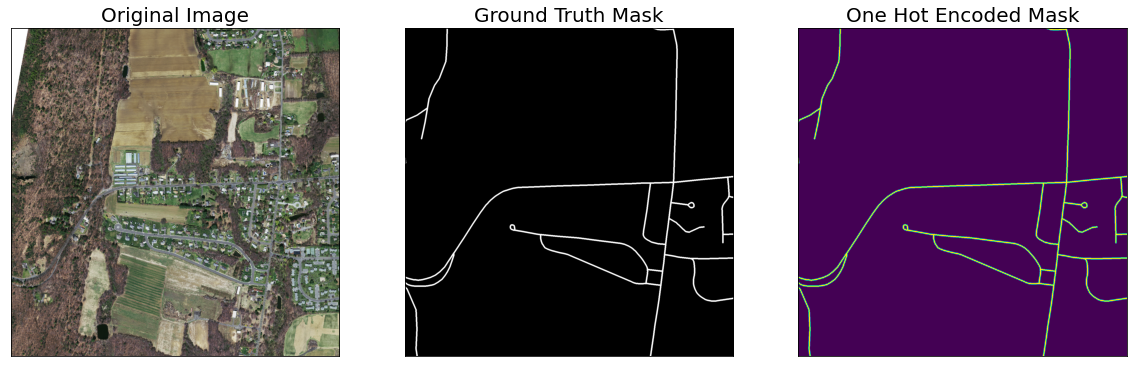

In [10]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [11]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

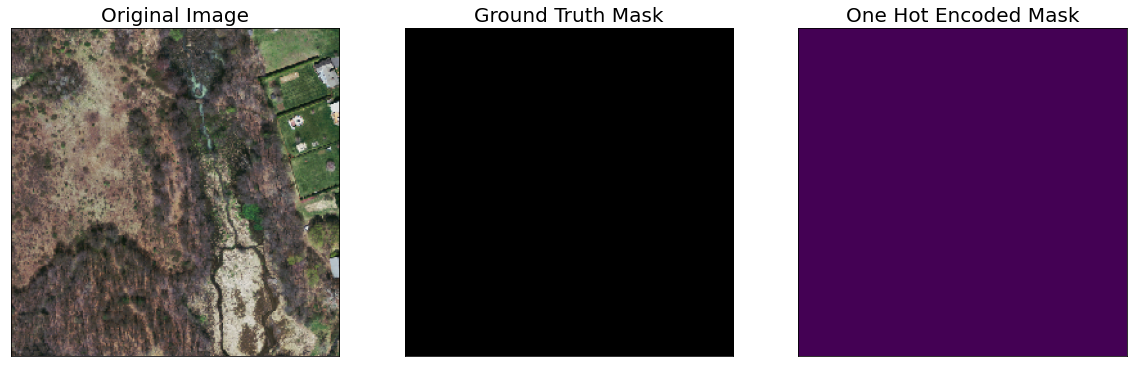

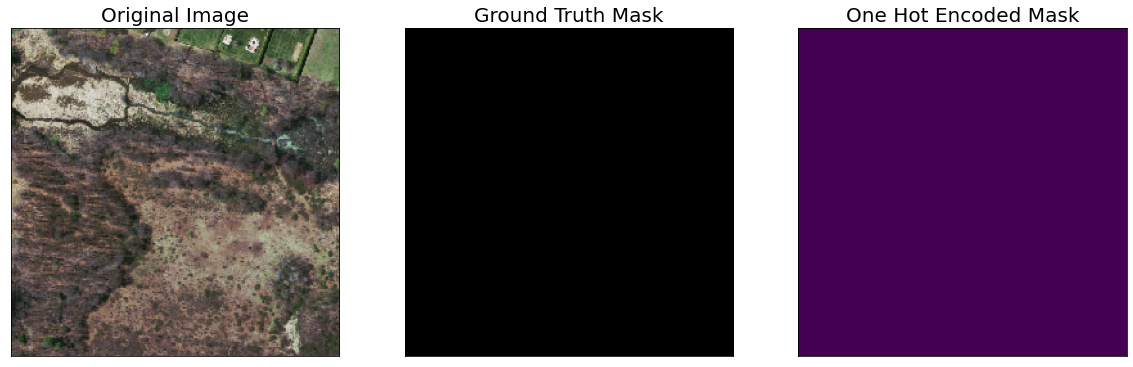

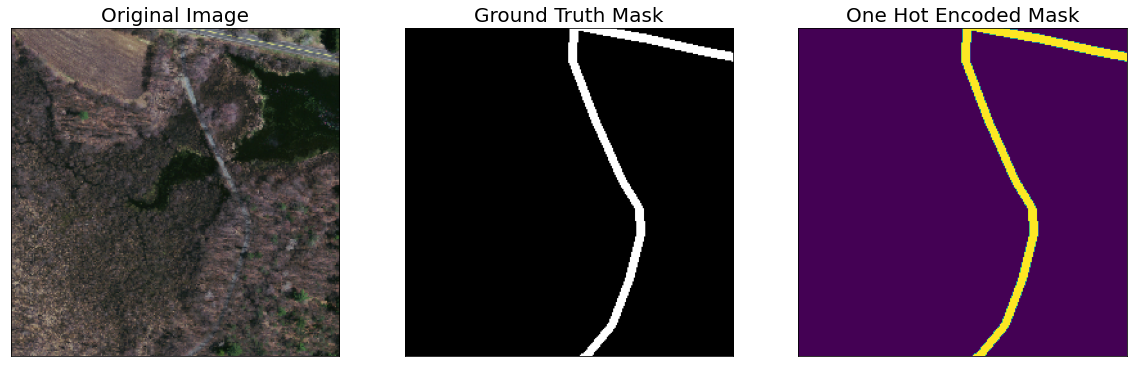

In [12]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_pan = smp.PAN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_deeplapv3 = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_linknet = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)


model_unetplustplus = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_deeplabv3plus = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_fpn = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)


model_manet = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_pspnet = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)


models = {"Unet": model_unet, "Unet++": model_unetplustplus,
          "DeepLabV3": model_deeplapv3, "DeepLabv3+": model_deeplabv3plus,
          "FPN": model_fpn, "MAnet": model_manet,
          "PAN": model_pan, "PSPNet": model_pspnet, "LinkNet": model_linknet}


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
def model_config(model):
    
    from segmentation_models_pytorch import utils
    
    
    
    loss = smp.utils.losses.DiceLoss()

    # define metrics
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
        smp.utils.metrics.Accuracy(),
        smp.utils.metrics.Fscore(),
        smp.utils.metrics.Precision(),
        smp.utils.metrics.Recall(),
        smp.utils.losses.JaccardLoss()
    ]

    # define loss function
    # define optimizer
    optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=0.00008),
    ])

    # define learning rate scheduler (not used in this NB)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=1, T_mult=2, eta_min=5e-5,
    )
    
    return loss, metrics, optimizer

In [15]:
models.keys()

dict_keys(['Unet', 'Unet++', 'DeepLabV3', 'DeepLabv3+', 'FPN', 'MAnet', 'PAN', 'PSPNet', 'LinkNet'])

In [16]:
%%time



TRAINING = True

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if TRAINING:
    logs = {}
    for model_name, model in models.items():
        
        

        loss, metrics, optimizer = model_config(model)

        train_epoch = smp.utils.train.TrainEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=DEVICE,
            verbose=True,
        )

        valid_epoch = smp.utils.train.ValidEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=True,
        )


        # Get train and val dataset instances
        # Get train and val dataset instances
        train_dataset = RoadsDataset(
            x_train_dir, y_train_dir, 
            augmentation=get_training_augmentation(),
            preprocessing=get_preprocessing(preprocessing_fn),
            class_rgb_values=select_class_rgb_values,
        )

        valid_dataset = RoadsDataset(
            x_valid_dir, y_valid_dir, 
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(preprocessing_fn),
            class_rgb_values=select_class_rgb_values,
        )

        # Get train and val data loaders
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
        
        print(40 * "-")
        print(40 * "-" + f" {model_name} " + 40*"-")
        
        train_logs_list, valid_logs_list = [], []
        
        best_iou_score = 0.0
    
        for i in range(0, EPOCHS):

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)
            
            
            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, f"./best_{model_name}.pth")
                print(f"{model_name} saved!")
                
            
            
        logs[model_name] = [train_logs_list, valid_logs_list]


----------------------------------------
---------------------------------------- Unet ----------------------------------------

Epoch: 0
valid: 100%|██████████| 14/14 [00:05<00:00,  2.50it/s, dice_loss - 0.2614, iou_score - 0.8053, accuracy - 0.8874, fscore - 0.8906, precision - 0.8382, recall - 0.9511, jaccard_loss - 0.4137]
Unet saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s, dice_loss - 0.1889, iou_score - 0.8364, accuracy - 0.9091, fscore - 0.9096, precision - 0.8707, recall - 0.9527, jaccard_loss - 0.3168]
Unet saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s, dice_loss - 0.1429, iou_score - 0.8542, accuracy - 0.9211, fscore - 0.9204, precision - 0.8903, recall - 0.9528, jaccard_loss - 0.249] 
Unet saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:05<00:00,  2.55it/s, dice_loss - 0.1108, iou_score - 0.8684, accuracy - 0.9304, fscore - 0.9289, precision - 0.9057, recall - 0.9534, jaccard_loss - 0.1987]
Unet saved!

Epoch: 4
valid: 100

In [17]:
from IPython.display import FileLink


files = [f"best_{model_name}.pth" for model_name in models.keys()]
links = []
for file in files:
    links.append(FileLink(file))

In [18]:
links[0]

/kaggle/working/best_Unet.pth

In [19]:
links[1]

/kaggle/working/best_Unet++.pth

In [20]:
links[2]

/kaggle/working/best_DeepLabV3.pth

In [21]:
links[3]

/kaggle/working/best_DeepLabv3+.pth

In [22]:
links[4]

/kaggle/working/best_FPN.pth

In [23]:
links[5]

/kaggle/working/best_MAnet.pth

In [24]:
links[6]

/kaggle/working/best_PAN.pth

In [25]:
links[7]

/kaggle/working/best_PSPNet.pth

In [26]:
links[8]

/kaggle/working/best_LinkNet.pth

In [27]:
model_names = ['Unet', 'Unet++', 'DeepLabV3', 'DeepLabv3+', 'FPN', 'MAnet', 'PAN', 'PSPNet', "LinkNet"]

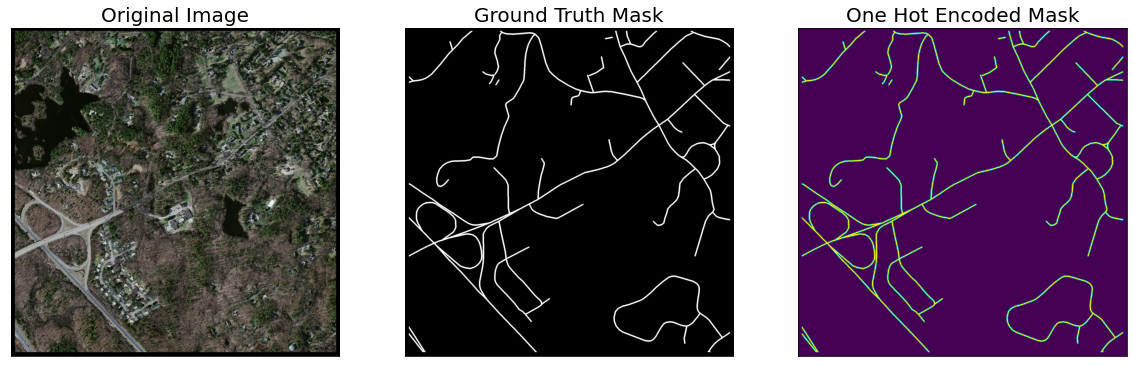

In [29]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [30]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [31]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

### Model Evaluation on Test Dataset

In [32]:
loss = smp.utils.losses.DiceLoss()

    # define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Precision(),
    smp.utils.metrics.Recall(),
    smp.utils.losses.JaccardLoss()
    ]

In [33]:
test_logs = {}
for model_name, model in models.items():
    
    print(40 * "-")
    print(40 * "-" + f" {model_name} " + 40*"-")

    test_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    valid_logs = test_epoch.run(test_dataloader)
    test_logs[model_name] = valid_logs
    print("Evaluation on Test Data: ")
    print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
    print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

----------------------------------------
---------------------------------------- Unet ----------------------------------------
valid: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s, dice_loss - 0.07575, iou_score - 0.908, accuracy - 0.9526, fscore - 0.9515, precision - 0.9288, recall - 0.9754, jaccard_loss - 0.1404] 
Evaluation on Test Data: 
Mean IoU Score: 0.9080
Mean Dice Loss: 0.0757
----------------------------------------
---------------------------------------- Unet++ ----------------------------------------
valid: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s, dice_loss - 0.09374, iou_score - 0.9104, accuracy - 0.9541, fscore - 0.9529, precision - 0.9328, recall - 0.9738, jaccard_loss - 0.171] 
Evaluation on Test Data: 
Mean IoU Score: 0.9104
Mean Dice Loss: 0.0937
----------------------------------------
---------------------------------------- DeepLabV3 ----------------------------------------
valid: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s, dice_loss - 0.08126, iou_s

In [34]:
model_names = test_logs.keys()

In [35]:
columns = ["dice_loss", "iou_score", "accuracy", "fscore", "precision", "recall", "jaccard_loss"]

In [36]:
test_logs

{'Unet': {'dice_loss': 0.0757479327065604,
  'iou_score': 0.907969174336414,
  'accuracy': 0.9526109123716551,
  'fscore': 0.9515294736745405,
  'precision': 0.9288413305671849,
  'recall': 0.9753541289543618,
  'jaccard_loss': 0.14038049079933945},
 'Unet++': {'dice_loss': 0.09374229883661077,
  'iou_score': 0.9103519685414372,
  'accuracy': 0.9540735823767527,
  'fscore': 0.9528595598376526,
  'precision': 0.9328083116181043,
  'recall': 0.9737955465608713,
  'jaccard_loss': 0.17104356386223615},
 'DeepLabV3': {'dice_loss': 0.08125976518708833,
  'iou_score': 0.8826939293316431,
  'accuracy': 0.9382174392135776,
  'fscore': 0.9372062318179074,
  'precision': 0.9104854975427903,
  'recall': 0.9655798831764532,
  'jaccard_loss': 0.14933335902739542},
 'DeepLabv3+': {'dice_loss': 0.10176400262482309,
  'iou_score': 0.8707587086424534,
  'accuracy': 0.9318439181970091,
  'fscore': 0.9302096938600345,
  'precision': 0.9088578163361063,
  'recall': 0.9525919289005047,
  'jaccard_loss': 0.1

In [37]:
data = {}
for model_name in model_names:
    for col in columns:
        if col not in list(data.keys()):
            data[col] = [test_logs[model_name][col]]
            #print(data)
        else:
            #print(data[col])
            data[col].append(test_logs[model_name][col])
            #print(data[col])

In [38]:
import pandas as pd

df = pd.DataFrame(data)
df.index = model_names
df

,dice_loss,iou_score,accuracy,fscore,precision,recall,jaccard_loss
Unet,0.075748,0.907969,0.952611,0.951529,0.928841,0.975354,0.140380
Unet++,0.093742,0.910352,0.954074,0.952860,0.932808,0.973796,0.171044
DeepLabV3,0.081260,0.882694,0.938217,0.937206,0.910485,0.965580,0.149333
DeepLabv3+,0.101764,0.870759,0.931844,0.930210,0.908858,0.952592,0.183404
FPN,0.069600,0.871112,0.932027,0.930415,0.908864,0.953013,0.128913
MAnet,0.080446,0.903855,0.950227,0.949227,0.924650,0.975154,0.148446
PAN,0.076090,0.871459,0.932257,0.930613,0.909519,0.952711,0.139962
PSPNet,0.086130,0.871112,0.932027,0.930415,0.908864,0.953013,0.157198
LinkNet,0.230356,0.844350,0.918846,0.915296,0.912551,0.918141,0.374281


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

<AxesSubplot:xlabel='iou_score'>

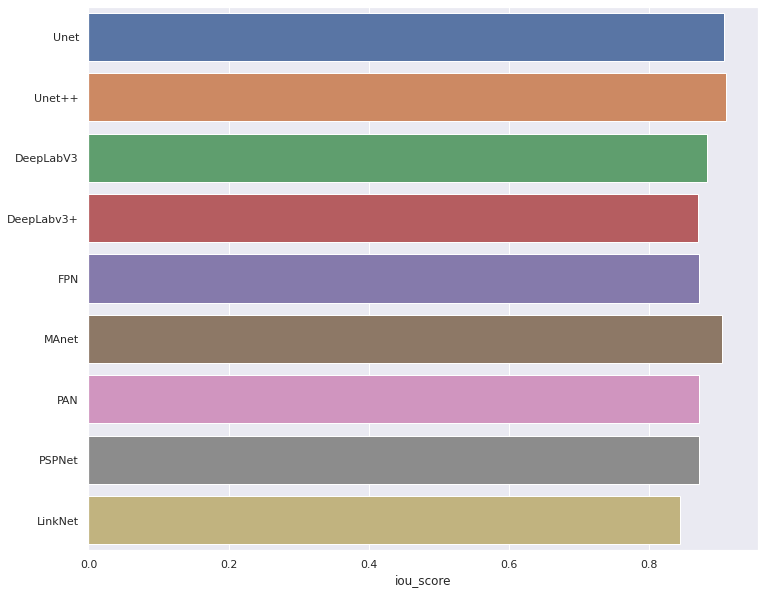

In [40]:
plt.figure(figsize=(12, 10))
sns.barplot(y=df.index, x=df['iou_score'])

In [41]:
logs.keys()

dict_keys(['Unet', 'Unet++', 'DeepLabV3', 'DeepLabv3+', 'FPN', 'MAnet', 'PAN', 'PSPNet', 'LinkNet'])

In [42]:
dice_train = {}
iou_train = {}

dice_test, iou_test = {}, {}

for model_name in model_names:
    dice_train[model_name]= [dic['dice_loss'] for dic in logs[model_name][0]]
    iou_train[model_name] = [dic['iou_score'] for dic in logs[model_name][0]]
    
    dice_test[model_name]= [dic['dice_loss'] for dic in logs[model_name][1]]
    iou_test[model_name] = [dic['iou_score'] for dic in logs[model_name][1]]

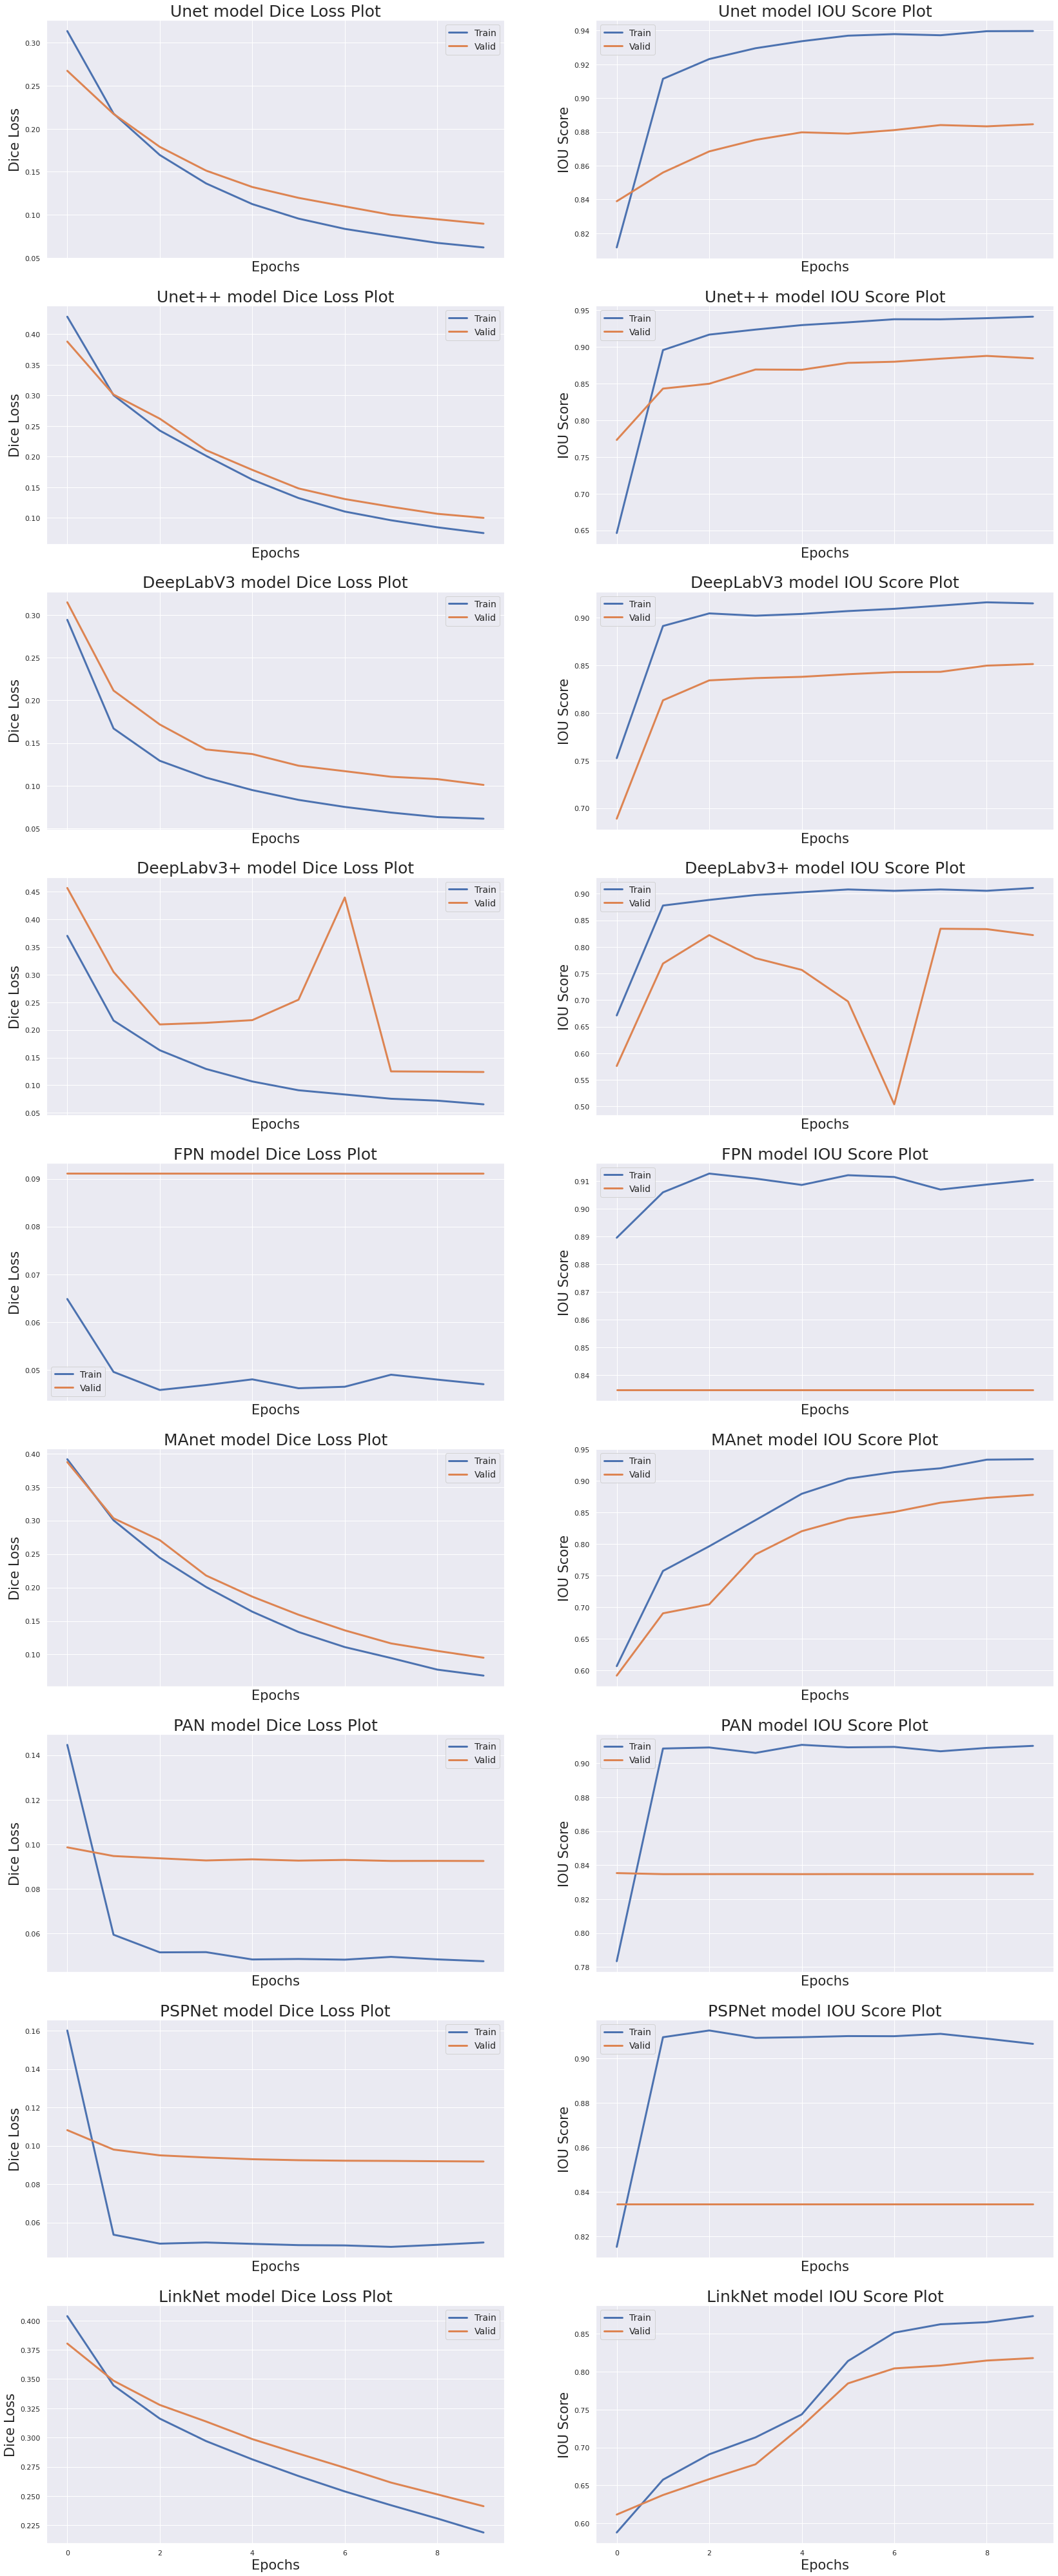

In [43]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(28, 8*9), sharex= True)



for row, model_name in enumerate(model_names):
    
    for col in range(2):
        #ax[0, col].figure(figsize=(20,8))
        if col == 0:
            ax[row, col].plot(range(10), dice_train[model_name], lw=3, label = 'Train')
            ax[row, col].plot(range(10), dice_test[model_name], lw=3, label = 'Valid')
            ax[row, col].set_xlabel('Epochs', fontsize=21)
            ax[row, col].set_ylabel(f"Dice Loss", fontsize=21)
            ax[row, col].set_title(f"{model_name} model Dice Loss Plot", fontsize=25)
            ax[row, col].legend(loc='best', fontsize=14)
            ax[row, col].grid("on")
        else:
            ax[row, col].plot(range(10), iou_train[model_name], lw=3, label = 'Train')
            ax[row, col].plot(range(10), iou_test[model_name], lw=3, label = 'Valid')
            ax[row, col].set_xlabel('Epochs', fontsize=21)
            ax[row, col].set_ylabel('IOU Score', fontsize=21)
            ax[row, col].set_title(f"{model_name} model IOU Score Plot", fontsize=25)
            ax[row, col].legend(loc='best', fontsize=14)
            ax[row, col].grid("on")
        #plt.savefig('dice_loss_plot.png')
plt.show()